## GPU Usage in Online Deep Learning

GPUs: 
* allow high degree of parallelization &rarr; yield significant speed-up over CPUs 
* are main contributors to the success of (batch) deep learning 

How useful are GPUs in online deep learning? 

In [1]:
# Imports and util functions
import pandas as pd
import torch
from itertools import product
from torch import nn
from time import time
from tqdm import tqdm
from deep_river.classification import Classifier
from river import compose, preprocessing, datasets, metrics
import matplotlib.pyplot as plt

from utils import seed_everything

# Load dataset define PyTorch module etc.
n_samples = 10_000
data = list(datasets.Insects(variant="abrupt_balanced").take(n_samples))

seed_everything(42)

# Define PyTorch module
class MyMLP(nn.Module):
    def __init__(self, n_features, hidden_units=64, hidden_layers=2):
        #super().__init__()
        super(MyMLP, self).__init__()
        self.linear1 = nn.Linear(n_features, hidden_units)
        self.hiddens = nn.ModuleList(
            [nn.Linear(hidden_units, hidden_units)] * (hidden_layers - 1)
        )
        self.linear3 = nn.Linear(hidden_units, 6)

    def forward(self, X, **kwargs):
        z = torch.relu(self.linear1(X))
        for layer in self.hiddens:
            z = torch.relu(layer(z))
        return torch.softmax(self.linear3(z), dim=-1)

INSECTS-abrupt_balanced_norm.arff


In [2]:
import pandas as pd
from tqdm import tqdm
from time import time

# Carregar CSV sem cabeçalho
csv_path = "/home/charan/river_data/tmp/USP DS Repository/INSECTS/INSECTS abrupt_balanced.csv"  # ajuste o caminho

# Definir nomes de colunas: 33 features + 1 label
feature_names = [f"feature_{i}" for i in range(33)]
column_names = feature_names + ['class']

df = pd.read_csv(csv_path, header=None, names=column_names)

# Pegar apenas as primeiras n_samples linhas
n_samples = 10_000
df = df.head(n_samples)

# Criar o scaler
scaler = preprocessing.StandardScaler()

# Converter para formato River
data = []
for idx, row in df.iterrows():
    x = {f"feature_{i}": row[f"feature_{i}"] for i in range(33)}
    y = int(row['class'])

    # Normalizar as features
    scaler.learn_one(x)
    x_normalized = scaler.transform_one(x)
    
    data.append((x_normalized, y))
    #data.append((x, y))

print(f"Dados carregados e normalizados: {len(data)} amostras")
print(f"Primeiro exemplo (normalizado): {list(data[0][0].items())[:3]}...")

Dados carregados e normalizados: 10000 amostras
Primeiro exemplo (normalizado): [('feature_0', 0.0), ('feature_1', 0.0), ('feature_2', 0.0)]...


In [3]:
df.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,919.515430,989.506903,1471.703848,1820.813891,2098.170921,2647.273497,1169.943821,0.255788,0.322839,0.338616,...,0.166223,0.181953,0.194202,0.177755,0.138091,0.101975,0.090285,0.104449,0.127636,6.348400
std,424.808899,496.106463,923.839879,1053.411824,1360.605275,1524.913147,334.815938,0.305648,0.315788,0.287272,...,0.235874,0.228236,0.246920,0.237375,0.195648,0.148889,0.129414,0.143394,0.181458,4.127508
min,41.679000,40.273000,36.881000,36.177000,35.802000,33.888000,262.970000,0.004504,0.003809,0.011826,...,0.006070,0.004439,0.005221,0.005443,0.004376,0.005810,0.003763,0.004040,0.002560,2.000000
25%,599.737500,602.845000,596.695000,1332.675000,387.412500,1764.875000,916.332500,0.061110,0.108397,0.140145,...,0.038581,0.045768,0.042024,0.034875,0.031040,0.028437,0.026797,0.029921,0.029705,3.000000
50%,864.100000,943.740000,1679.150000,1980.800000,2408.950000,2927.050000,1118.850000,0.145660,0.227710,0.260410,...,0.078166,0.094101,0.089887,0.072227,0.057430,0.047634,0.044704,0.050023,0.051842,4.000000
75%,1173.125000,1285.375000,2065.450000,2488.150000,3061.900000,3699.650000,1383.925000,0.332043,0.431412,0.446275,...,0.182640,0.220532,0.243393,0.225850,0.153830,0.104295,0.092380,0.107465,0.136502,11.000000
max,2277.600000,3610.500000,7845.500000,7878.100000,7874.200000,8001.800000,2967.700000,4.365200,4.336700,3.173200,...,3.776600,2.438800,2.338300,2.212100,2.385800,3.752900,2.518400,1.865500,2.085600,12.000000


In [15]:
# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available.")
    print("GPU:", torch.cuda.get_device_name(0))
    # Set device to use to GPU with index 0
    dev = "cuda:0"
else:
    print("CUDA is not available.")
    dev = "cpu"

CUDA is available.
GPU: Quadro P620


In [5]:
# Create classification model
model = Classifier(
    module=MyMLP(n_features=33),
    loss_fn='cross_entropy', optimizer_fn='sgd', lr=0.5, device=dev)

metric = metrics.Accuracy()

start = time()
# Run anomaly detection model using GPU (if available)
for x, y in tqdm(data):
    # Predict and train on current instance
    pred = model.predict_one(x)
    model.learn_one(x, y)
    # Record results
    metric.update(y, pred)

print("\nGPU Runtime: {:.2f} Seconds".format(time() - start))
print(f"GPU Accuracy: {metric.get():.2%}\n")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 857.00it/s]


GPU Runtime: 11.67 Seconds
GPU Accuracy: 45.41%



In [6]:
# Create anomaly detection pipeline
model = Classifier(module=MyMLP(n_features=33),
                   loss_fn='cross_entropy', optimizer_fn='sgd', lr=0.5, device="cpu")

metric = metrics.Accuracy()

start = time()
# Run anomaly detection pipeline using GPU (if available)
for x, y in tqdm(data):
    # Predict and train on current instance
    pred = model.predict_one(x)
    model.learn_one(x, y)
    # Record results
    metric.update(y, pred)

print("\nCPU Runtime: {:.2f} Seconds".format(time() - start))
print(f"CPU Accuracy: {metric.get():.2%}\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1538.79it/s]


CPU Runtime: 6.50 Seconds
CPU Accuracy: 38.23%



* The pipeline runs significantly faster on the CPU! 
* Why? 
    + Small Network
    + Batch Size = 1 
* &rarr; Very little parallelism
* What happens if we increase the batch size by buffering training instances? 

![Sample Buffering](../resources/sample_buffering.png)

In [7]:
# Verificar a escala dos dados
import numpy as np

# Pegar as primeiras 1000 amostras para análise
sample_data = [list(x.values()) for x, y in data[:1000]]
sample_array = np.array(sample_data)

print("Estatísticas das features:")
print(f"Min: {sample_array.min(axis=0)[:5]}")  # primeiras 5 features
print(f"Max: {sample_array.max(axis=0)[:5]}")
print(f"Mean: {sample_array.mean(axis=0)[:5]}")
print(f"Std: {sample_array.std(axis=0)[:5]}")

Estatísticas das features:
Min: [-2.48380565 -1.99301519 -1.72169034 -2.14137941 -1.50020581]
Max: [2.7605287  3.72398467 3.06021977 2.79327709 3.22084521]
Mean: [-0.04601519  0.07884023 -0.0275937  -0.01153438  0.00715434]
Std: [1.03961284 1.01199284 1.01274648 1.03747649 0.96455007]


In [16]:
# Implement class that buffers samples until desired batch size is reached
class StreamBuffer:
    def __init__(self, size=8) -> None:
        self.xs = []
        self.ys = []
        self.size = size
        self.current_size = 0
        self.is_full = False

    def append(self, x: dict, y: int = None):
        # Converter valores para float explicitamente
        #self.xs.append([float(v) for v in x.values()])
        self.xs.append(x)
        self.ys.append(int(y))
        #self.xs.append(list(x.values()))
        #self.ys.append(y)
        if len(self.ys) == self.size:
            self.is_full = True

    def get(self):
        self.is_full = False
        #result = pd.DataFrame.from_records(self.xs), pd.Series(self.ys)
        result = pd.DataFrame(self.xs), pd.Series(self.ys)
        self.xs.clear()
        self.ys.clear()
        return result

learningRate = 0.1
optimizer='adam'
# Implement function to train
def run_batch_wise(batch_size, device, verbose=True):
    # Add a buffer storing samples until desired batch size is reached
    buffer = StreamBuffer(size=batch_size)
    model = Classifier(module=MyMLP(n_features=33),
                   loss_fn='cross_entropy', optimizer_fn=optimizer, lr=learningRate, device=device)
    metric = metrics.Accuracy()

    start = time()
    iterator = tqdm(data) if verbose else data
    for x, y in iterator:
        pred = model.predict_one(x)  # TODO: Remove this for "hands-on" blank text?
        metric.update(y, pred)

        # Store samples in buffer
        buffer.append(x, y)

        # Perform updates once buffer is full
        if buffer.is_full:
            x_batch, y_batch = buffer.get()
            model.learn_many(x_batch, y_batch)

    return metric.get(), time() - start

# Criar um pipeline com normalização
def run_batch_wise_normalized(batch_size, device, verbose=True):
    buffer = StreamBuffer(size=batch_size)
    
    # Adicionar StandardScaler para normalizar as features
    scaler = preprocessing.StandardScaler()
    
    model = Classifier(
        module=MyMLP(n_features=33, hidden_units=64, hidden_layers=2),
        loss_fn='cross_entropy', 
        optimizer_fn=optimizer, 
        lr=learningRate, 
        device=device
    )
    
    metric = metrics.Accuracy()
    start = time()
    iterator = tqdm(data) if verbose else data

    for x, y in iterator:
        # Normalizar: primeiro aprende, depois transforma
        scaler.learn_one(x)
        x_scaled = scaler.transform_one(x)
        
        pred = model.predict_one(x_scaled)
        metric.update(y, pred)
        buffer.append(x_scaled, y)
        
        if buffer.is_full:
            x_batch, y_batch = buffer.get()
            model.learn_many(x_batch, y_batch)
            
   
    return metric.get(), time() - start

#accuracy, runtime = run_batch_wise(batch_size=8, device="cpu")
#print("CPU Runtime: {:.2f} Seconds \n".format(runtime))
#accuracy, runtime = run_batch_wise(batch_size=8, device=dev)
#print("\nGPU Runtime: {:.2f} Seconds".format(runtime))

# # Executar com normalização
# print("=== COM NORMALIZAÇÃO ===\n")

# accuracy, runtime = run_batch_wise_normalized(batch_size=8, device="cpu")
# print(f"CPU Runtime: {runtime:.2f} segundos")
# print(f"CPU Accuracy: {accuracy:.2%}\n")

# accuracy, runtime = run_batch_wise_normalized(batch_size=8, device=dev)
# print(f"GPU Runtime: {runtime:.2f} segundos")
# print(f"GPU Accuracy: {accuracy:.2%}")

print("=" * 50)
print("SEM NORMALIZAÇÃO")
print("=" * 50)
accuracy_cpu, runtime_cpu = run_batch_wise(batch_size=8, device="cpu")
print(f"CPU - Tempo: {runtime_cpu:.2f}s | Acurácia: {accuracy_cpu:.2%}\n")

accuracy_gpu, runtime_gpu = run_batch_wise(batch_size=8, device=dev)
print(f"GPU - Tempo: {runtime_gpu:.2f}s | Acurácia: {accuracy_gpu:.2%}")

print("\n" + "=" * 50)
print("COM NORMALIZAÇÃO")
print("=" * 50)
accuracy_cpu_norm, runtime_cpu_norm = run_batch_wise_normalized(batch_size=8, device="cpu")
print(f"CPU - Tempo: {runtime_cpu_norm:.2f}s | Acurácia: {accuracy_cpu_norm:.2%}\n")

accuracy_gpu_norm, runtime_gpu_norm = run_batch_wise_normalized(batch_size=8, device=dev)
print(f"GPU - Tempo: {runtime_gpu_norm:.2f}s | Acurácia: {accuracy_gpu_norm:.2%}")

# print("\n" + "=" * 50)
# print("COMPARAÇÃO")
# print("=" * 50)
# print(f"Melhoria na acurácia: {(accuracy_gpu_norm - accuracy_gpu)*100:.2f} pontos percentuais")
# print(f"Speedup GPU: {runtime_cpu_norm/runtime_gpu_norm:.2f}x")

SEM NORMALIZAÇÃO


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1193.67it/s]


CPU - Tempo: 8.38s | Acurácia: 18.78%



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1070.60it/s]


GPU - Tempo: 9.34s | Acurácia: 18.78%

COM NORMALIZAÇÃO


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1161.90it/s]


CPU - Tempo: 8.61s | Acurácia: 5.10%



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1005.53it/s]

GPU - Tempo: 9.95s | Acurácia: 5.10%


* The GPU still yields no increase in execution speed. 
* How large does the batch size have to get for the GPU to be preferable? 

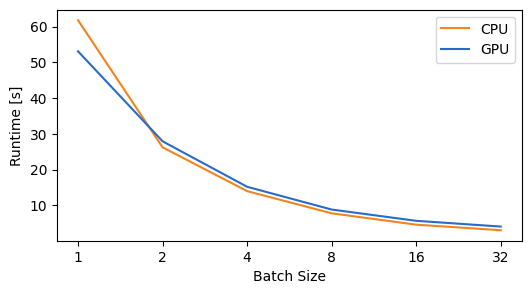

In [9]:
batch_sizes = [2**i for i in range(6)]
results = []
for dev in ["cpu", "cuda:0"]:
    dname = "GPU" if dev == "cuda:0" else "CPU"
    for batch_size in batch_sizes:
        accuracy, runtime = run_batch_wise(batch_size, dev, verbose=False)
        results.append(
            {
                "runtime": runtime,
                "accuracy": accuracy,
                "device": dname,
                "batch_size": batch_size,
            }
        )


df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(6, 3))
colors = {"CPU": "#F3841D", "GPU": "#286BC8"}
for dev, dfd in df.groupby("device"):
    ax.plot(dfd["batch_size"], dfd["runtime"], label=dev, c=colors[dev])
ax.set_xlabel("Batch Size")
ax.set_ylabel("Runtime [s]")
net_widths = df["batch_size"].unique()
ax.set_xscale("log", base=2)
ax.set_xticks(net_widths)
ax.set_xticklabels(net_widths)
l = ax.legend()

* GPU training is bottlenecked by data transfer between System and GPU memory
* CPU remains faster even at relatively large batch sizes
* What about larger models?
* How large must the network be to run faster on the GPU?

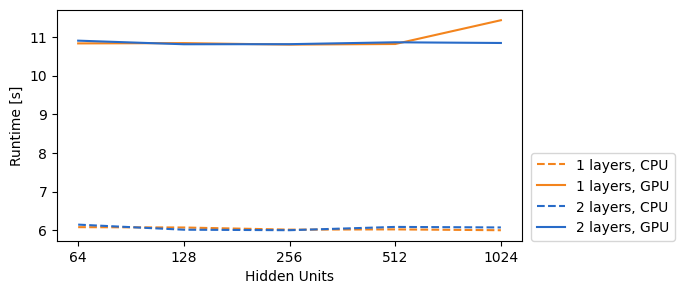

In [10]:

# Test runtime for increasingly wider MLPs with one or two hidden layers:
results = []
configs = product([1, 2], [2**i for i in range(6, 11)], ["cpu", "cuda:0"])
for net_depth, net_width, dev in list(configs):
    dname = "GPU" if dev == "cuda:0" else "CPU"
    model = Classifier(
        module=MyMLP(n_features=33),
        lr=0.5,
        device=dev,
        loss_fn='cross_entropy', 
        optimizer_fn='sgd',
        hidden_units=net_width,
        hidden_layers=net_depth,
    )
    metric = metrics.Accuracy()

    start = time()

    for x, y in data:
        # Predict and train on current instance
        pred = model.predict_one(x)
        model.learn_one(x, y)
        # Record results
        metric.update(y, pred)
    results.append(
        {
            "runtime": time() - start,
            "accuracy": metric.get(),
            "device": dname,
            "hidden_units": net_width,
            "hidden_layers": net_depth,
        }
    )

df = pd.DataFrame(results)
df = df.sort_values(by="hidden_units")
fig, ax = plt.subplots(figsize=(6, 3))
colors = {1: "#F3841D", 2: "#286BC8"}
styles = {"CPU": "dashed", "GPU": "solid"}
for (hidden_layers, dev), dfd in df.groupby(["hidden_layers", "device"]):
    ax.plot(
        dfd["hidden_units"],
        dfd["runtime"],
        label=f"{hidden_layers} layers, {dev}",
        c=colors[hidden_layers],
        linestyle=styles[dev],
    )
ax.set_xlabel("Hidden Units")
ax.set_ylabel("Runtime [s]")
net_widths = df["hidden_units"].unique()
ax.set_xscale("log", base=2)
ax.set_xticks(net_widths)
ax.set_xticklabels(net_widths)
l = ax.legend(loc=(1.02, 0))

* Difficult to reach parameter count where GPU is faster with only one hidden layer
* GPU yields better runtime for wide network with two hidden layers
* In batch learning: larger model &rarr; better performance &rarr; GPUs are mandatory
* Is the same true in online deep learning?

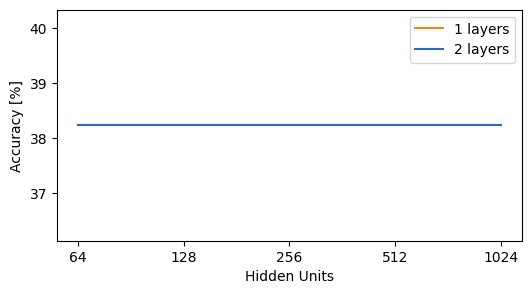

In [11]:
dfc = df[(df["device"] == "CPU")]
fig, ax = plt.subplots(figsize=(6, 3))
for hidden_layers, dfl in dfc.groupby("hidden_layers"):
    ax.plot(
        dfl["hidden_units"],
        dfl["accuracy"] * 100,
        label=f"{hidden_layers} layers",
        color=colors[hidden_layers],
    )
ax.set_xlabel("Hidden Units")
ax.set_ylabel("Accuracy [%]")
net_widths = dfl["hidden_units"]
ax.set_xscale("log", base=2)
ax.set_xticks(net_widths)
ax.set_xticklabels(net_widths)
l= ax.legend()

* Average accuracy increases with network width 
* Deeper model performs significantly worse than shallower model
* Explanation: additional ReLU layer increases gradient sparsity, slowing convergence 

In [12]:
results

[{'runtime': 6.08160662651062,
  'accuracy': 0.3823,
  'device': 'CPU',
  'hidden_units': 64,
  'hidden_layers': 1},
 {'runtime': 10.833198308944702,
  'accuracy': 0.4541,
  'device': 'GPU',
  'hidden_units': 64,
  'hidden_layers': 1},
 {'runtime': 6.072932481765747,
  'accuracy': 0.3823,
  'device': 'CPU',
  'hidden_units': 128,
  'hidden_layers': 1},
 {'runtime': 10.840869903564453,
  'accuracy': 0.4541,
  'device': 'GPU',
  'hidden_units': 128,
  'hidden_layers': 1},
 {'runtime': 6.017433404922485,
  'accuracy': 0.3823,
  'device': 'CPU',
  'hidden_units': 256,
  'hidden_layers': 1},
 {'runtime': 10.802127122879028,
  'accuracy': 0.4541,
  'device': 'GPU',
  'hidden_units': 256,
  'hidden_layers': 1},
 {'runtime': 6.0241265296936035,
  'accuracy': 0.3823,
  'device': 'CPU',
  'hidden_units': 512,
  'hidden_layers': 1},
 {'runtime': 10.817813873291016,
  'accuracy': 0.4541,
  'device': 'GPU',
  'hidden_units': 512,
  'hidden_layers': 1},
 {'runtime': 6.002447128295898,
  'accuracy': 